In [1]:
import torch
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image, ImageOps

import torch.nn as nn

import models.MathNet as mnt
import models.MathNet20 as mnt20
import models.MathNet56 as mnt56

In [2]:
BATCH_SIZE = 128
EPOCHS = 31
IMAGE_SIZE = 224

In [3]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
    #transforms.Normalize(std=0.5, mean=0.2)
    
])
# the validation transforms
valid_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
])

In [42]:
dataset = torchvision.datasets.ImageFolder(r'G:\TRAIN\dataset_balance', transform=train_transform)
print(len(dataset))

123953


In [43]:
classes_dict = dataset.class_to_idx
classes = []
for key in classes_dict.keys():
    classes.append(str(key))
classes.sort()
classes

['(',
 ')',
 '+',
 ',',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'F',
 'alpha',
 'and',
 'beta',
 'delta',
 'exists',
 'forall',
 'gamma',
 'lambda',
 'mu',
 'not',
 'omega',
 'or',
 'phi',
 'pi',
 'psi',
 'rightarrow',
 'sigma',
 'tau',
 'theta',
 'upsilon',
 'x',
 'y',
 'z']

In [44]:
# classes = ['(', ')', ',', '-', 
#                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
#                    'A', '[', 'α', 'and', 'β', '∃', 'F', '∀', 
#                    'γ', 'λ', 'μ', 'ω', 'or', 'φ', '→', 
#                    'σ', 'sqrt', 'θ', 'v', 'x', 'y', 'z']

NUM_CLASSES = len(classes)

def map_pred(ind):
    if ind < NUM_CLASSES:
        return classes[ind]
    return 'ERROR MAPPIMG'

NUM_CLASSES

40

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda', index=0)

In [46]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

In [47]:
mean, std = dataset[0][0].mean(), dataset[0][0].std()
print(mean, std)

tensor(0.7992) tensor(0.3780)


In [48]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [51]:
datasets = train_val_dataset(dataset)
print(type(datasets['train']))
print(len(datasets['val']))
# The original dataset is avail


<class 'torch.utils.data.dataset.Subset'>
24791


In [53]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 123953
    Root location: G:\TRAIN\dataset_balance
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )


24791
10


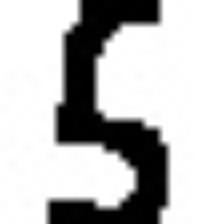

In [54]:
# training dataset
train_dataset = datasets['train']
# validation dataset
valid_dataset = (datasets['val'])
# training data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=6, pin_memory=True
)
# validation data loaders
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=6, pin_memory=True
)
# training data loaders

train_dataset
print(len(valid_dataset))
print(valid_dataset[15551][1])
#print(valid_dataset.dataset.targets)
aaa = transforms.ToPILImage()
display(aaa(valid_dataset[15551][0]))

In [55]:
from collections import Counter
#train_classes = [label for _, label in valid_dataset]
#Counter(train_classes)
train_classes = [dataset.targets[i] for i in train_dataset.indices]
valid_classes = [dataset.targets[i] for i in valid_dataset.indices]
print(Counter(train_classes))
print(Counter(valid_classes))


Counter({30: 4650, 4: 4569, 27: 3613, 35: 3418, 32: 3272, 39: 3164, 10: 3122, 22: 3115, 18: 3076, 29: 3055, 38: 2956, 15: 2919, 7: 2802, 6: 2792, 36: 2738, 9: 2680, 37: 2623, 17: 2608, 14: 2543, 26: 2541, 0: 2497, 13: 2489, 28: 2444, 5: 2437, 1: 2405, 12: 2378, 23: 2315, 21: 2304, 11: 2268, 8: 2164, 2: 2083, 19: 2070, 16: 1750, 3: 1519, 25: 1288, 33: 1221, 20: 1017, 31: 888, 24: 880, 34: 489})
Counter({30: 1125, 4: 1064, 27: 947, 35: 902, 32: 868, 22: 827, 18: 794, 36: 768, 10: 754, 29: 751, 39: 730, 7: 714, 37: 710, 15: 693, 38: 692, 6: 688, 17: 662, 9: 656, 13: 649, 14: 637, 0: 605, 5: 602, 26: 597, 1: 594, 11: 588, 28: 580, 12: 568, 21: 564, 8: 554, 23: 546, 2: 538, 19: 516, 16: 482, 3: 387, 25: 335, 33: 304, 20: 229, 31: 227, 24: 225, 34: 119})


In [56]:
d = dict(Counter(valid_dataset.dataset.targets))
print(d)

{0: 3102, 1: 2999, 2: 2621, 3: 1906, 4: 5633, 5: 3039, 6: 3480, 7: 3516, 8: 2718, 9: 3336, 10: 3876, 11: 2856, 12: 2946, 13: 3138, 14: 3180, 15: 3612, 16: 2232, 17: 3270, 18: 3870, 19: 2586, 20: 1246, 21: 2868, 22: 3942, 23: 2861, 24: 1105, 25: 1623, 26: 3138, 27: 4560, 28: 3024, 29: 3806, 30: 5775, 31: 1115, 32: 4140, 33: 1525, 34: 608, 35: 4320, 36: 3506, 37: 3333, 38: 3648, 39: 3894}


<Axes: ylabel='Сharactrs'>

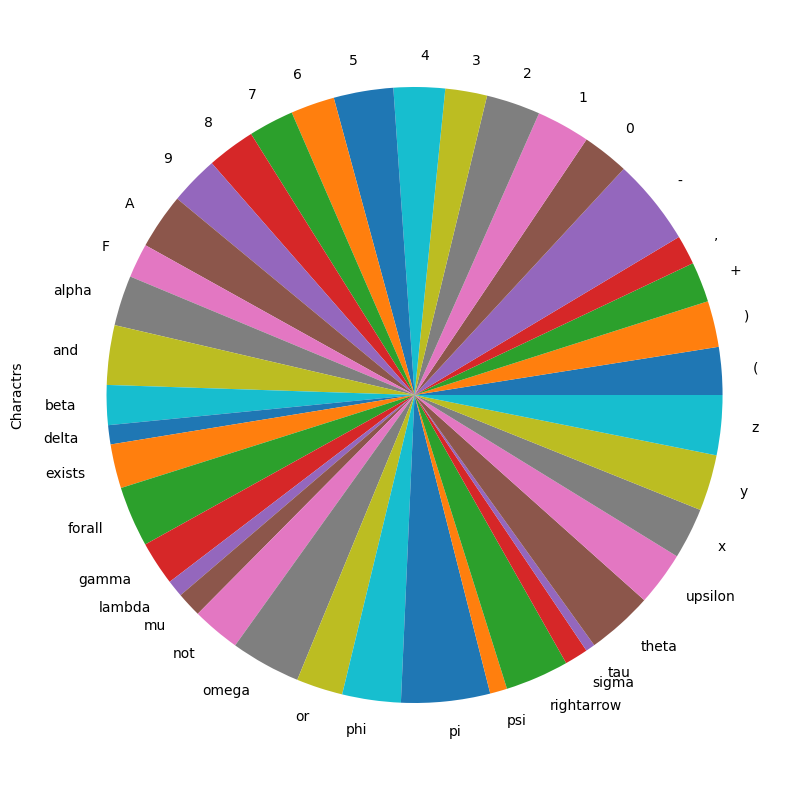

In [57]:
import pandas as pd
df = pd.Series(data=d,name='Сharactrs')    
df.plot(labels=classes,kind='pie',figsize=(10,10))

In [58]:
# training
def train(model, trainloader, optimizer, loss_function):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainloader))):
        counter += 1
        optimizer.zero_grad()
        x, y = data
        x = x.to(device)      
        y = y.to(device)       
        outputs = model.forward(x)
        loss = loss_function(outputs, y)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == y).sum().item()
        loss.backward()
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [59]:
def validate(model, testloader, loss_function):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=int(len(testloader))):
            counter += 1
            x, y = data
            x = x.to(device)      
            y = y.to(device)
            # forward pass
            outputs = model(x)
            # calculate the loss
            loss = loss_function(outputs, y)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == y).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [60]:
if (IMAGE_SIZE == 56):
    model = mnt56.MathNet56()
elif (IMAGE_SIZE == 224):
    model = mnt.MathNet()

model = mnt.MathNet()

torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model = model.to(device)
device
type(model)

models.MathNet.MathNet

In [61]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

In [62]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, label=''):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_accuracy'+label+'.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_loss'+label+'.png')

In [63]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, loss)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 loss)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
    torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet'+str(epoch)+'.ml')
    
# save the trained model weights
torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet.ml')
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 31
Training


100%|██████████| 775/775 [02:05<00:00,  6.16it/s]


Validation


100%|██████████| 194/194 [00:23<00:00,  8.24it/s]


Training loss: 0.415, training acc: 90.172
Validation loss: 0.174, validation acc: 95.458
--------------------------------------------------
[INFO]: Epoch 2 of 31
Training


100%|██████████| 775/775 [02:04<00:00,  6.24it/s]


Validation


100%|██████████| 194/194 [00:10<00:00, 17.90it/s]


Training loss: 0.121, training acc: 96.675
Validation loss: 0.106, validation acc: 96.854
--------------------------------------------------
[INFO]: Epoch 3 of 31
Training


100%|██████████| 775/775 [02:03<00:00,  6.25it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 16.40it/s]


Training loss: 0.094, training acc: 97.342
Validation loss: 0.104, validation acc: 97.063
--------------------------------------------------
[INFO]: Epoch 4 of 31
Training


100%|██████████| 775/775 [02:04<00:00,  6.21it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.01it/s]


Training loss: 0.081, training acc: 97.614
Validation loss: 0.090, validation acc: 97.523
--------------------------------------------------
[INFO]: Epoch 5 of 31
Training


100%|██████████| 775/775 [02:03<00:00,  6.29it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 16.73it/s]


Training loss: 0.074, training acc: 97.793
Validation loss: 0.081, validation acc: 97.568
--------------------------------------------------
[INFO]: Epoch 6 of 31
Training


100%|██████████| 775/775 [02:03<00:00,  6.28it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 16.44it/s]


Training loss: 0.066, training acc: 97.986
Validation loss: 0.079, validation acc: 97.564
--------------------------------------------------
[INFO]: Epoch 7 of 31
Training


100%|██████████| 775/775 [02:04<00:00,  6.22it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 16.35it/s]


Training loss: 0.060, training acc: 98.149
Validation loss: 0.084, validation acc: 97.459
--------------------------------------------------
[INFO]: Epoch 8 of 31
Training


100%|██████████| 775/775 [02:05<00:00,  6.20it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.48it/s]


Training loss: 0.056, training acc: 98.282
Validation loss: 0.068, validation acc: 97.943
--------------------------------------------------
[INFO]: Epoch 9 of 31
Training


100%|██████████| 775/775 [02:06<00:00,  6.12it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.49it/s]


Training loss: 0.052, training acc: 98.351
Validation loss: 0.069, validation acc: 97.822
--------------------------------------------------
[INFO]: Epoch 10 of 31
Training


100%|██████████| 775/775 [02:07<00:00,  6.08it/s]


Validation


100%|██████████| 194/194 [00:10<00:00, 18.05it/s]


Training loss: 0.048, training acc: 98.485
Validation loss: 0.068, validation acc: 97.959
--------------------------------------------------
[INFO]: Epoch 11 of 31
Training


100%|██████████| 775/775 [02:07<00:00,  6.07it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.49it/s]


Training loss: 0.046, training acc: 98.530
Validation loss: 0.057, validation acc: 98.270
--------------------------------------------------
[INFO]: Epoch 12 of 31
Training


100%|██████████| 775/775 [02:07<00:00,  6.06it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.17it/s]


Training loss: 0.044, training acc: 98.550
Validation loss: 0.064, validation acc: 98.112
--------------------------------------------------
[INFO]: Epoch 13 of 31
Training


100%|██████████| 775/775 [02:07<00:00,  6.06it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.57it/s]


Training loss: 0.039, training acc: 98.726
Validation loss: 0.073, validation acc: 97.798
--------------------------------------------------
[INFO]: Epoch 14 of 31
Training


100%|██████████| 775/775 [02:07<00:00,  6.06it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.39it/s]


Training loss: 0.038, training acc: 98.774
Validation loss: 0.057, validation acc: 98.342
--------------------------------------------------
[INFO]: Epoch 15 of 31
Training


100%|██████████| 775/775 [02:08<00:00,  6.04it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.53it/s]


Training loss: 0.036, training acc: 98.799
Validation loss: 0.064, validation acc: 98.044
--------------------------------------------------
[INFO]: Epoch 16 of 31
Training


100%|██████████| 775/775 [02:08<00:00,  6.04it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.62it/s]


Training loss: 0.031, training acc: 98.958
Validation loss: 0.062, validation acc: 98.157
--------------------------------------------------
[INFO]: Epoch 17 of 31
Training


100%|██████████| 775/775 [02:09<00:00,  6.00it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.63it/s]


Training loss: 0.032, training acc: 98.910
Validation loss: 0.090, validation acc: 97.519
--------------------------------------------------
[INFO]: Epoch 18 of 31
Training


100%|██████████| 775/775 [02:06<00:00,  6.13it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.54it/s]


Training loss: 0.029, training acc: 99.012
Validation loss: 0.059, validation acc: 98.286
--------------------------------------------------
[INFO]: Epoch 19 of 31
Training


100%|██████████| 775/775 [02:05<00:00,  6.16it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.62it/s]


Training loss: 0.028, training acc: 99.080
Validation loss: 0.072, validation acc: 97.995
--------------------------------------------------
[INFO]: Epoch 20 of 31
Training


100%|██████████| 775/775 [02:08<00:00,  6.01it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.31it/s]


Training loss: 0.028, training acc: 99.063
Validation loss: 0.066, validation acc: 98.003
--------------------------------------------------
[INFO]: Epoch 21 of 31
Training


100%|██████████| 775/775 [02:08<00:00,  6.05it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.56it/s]


Training loss: 0.024, training acc: 99.160
Validation loss: 0.069, validation acc: 97.967
--------------------------------------------------
[INFO]: Epoch 22 of 31
Training


100%|██████████| 775/775 [02:07<00:00,  6.06it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.48it/s]


Training loss: 0.023, training acc: 99.187
Validation loss: 0.054, validation acc: 98.520
--------------------------------------------------
[INFO]: Epoch 23 of 31
Training


100%|██████████| 775/775 [02:08<00:00,  6.05it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 17.37it/s]


Training loss: 0.024, training acc: 99.160
Validation loss: 0.053, validation acc: 98.524
--------------------------------------------------
[INFO]: Epoch 24 of 31
Training


100%|██████████| 775/775 [02:07<00:00,  6.08it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 16.41it/s]


Training loss: 0.021, training acc: 99.262
Validation loss: 0.321, validation acc: 91.194
--------------------------------------------------
[INFO]: Epoch 25 of 31
Training


100%|██████████| 775/775 [02:05<00:00,  6.18it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 16.53it/s]


Training loss: 0.021, training acc: 99.300
Validation loss: 0.057, validation acc: 98.350
--------------------------------------------------
[INFO]: Epoch 26 of 31
Training


100%|██████████| 775/775 [02:04<00:00,  6.24it/s]


Validation


100%|██████████| 194/194 [00:10<00:00, 17.86it/s]


Training loss: 0.020, training acc: 99.346
Validation loss: 0.051, validation acc: 98.620
--------------------------------------------------
[INFO]: Epoch 27 of 31
Training


100%|██████████| 775/775 [02:03<00:00,  6.29it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 16.43it/s]


Training loss: 0.020, training acc: 99.309
Validation loss: 0.058, validation acc: 98.443
--------------------------------------------------
[INFO]: Epoch 28 of 31
Training


100%|██████████| 775/775 [02:05<00:00,  6.17it/s]


Validation


100%|██████████| 194/194 [00:11<00:00, 16.23it/s]


Training loss: 0.018, training acc: 99.397
Validation loss: 0.050, validation acc: 98.717
--------------------------------------------------
[INFO]: Epoch 29 of 31
Training


100%|██████████| 775/775 [02:07<00:00,  6.06it/s]


Validation


100%|██████████| 194/194 [00:10<00:00, 18.48it/s]


Training loss: 0.016, training acc: 99.457
Validation loss: 0.235, validation acc: 94.091
--------------------------------------------------
[INFO]: Epoch 30 of 31
Training


 67%|██████▋   | 518/775 [01:22<00:40,  6.30it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torch\utils\data\dataset.py", line 364, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torch\utils\data\dataset.py", line 364, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torchvision\datasets\folder.py", line 229, in __getitem__
    sample = self.loader(path)
             ^^^^^^^^^^^^^^^^^
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torchvision\datasets\folder.py", line 268, in default_loader
    return pil_loader(path)
           ^^^^^^^^^^^^^^^^
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torchvision\datasets\folder.py", line 246, in pil_loader
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'G:\\TRAIN\\dataset_balance\\tau\\293325.jpg'


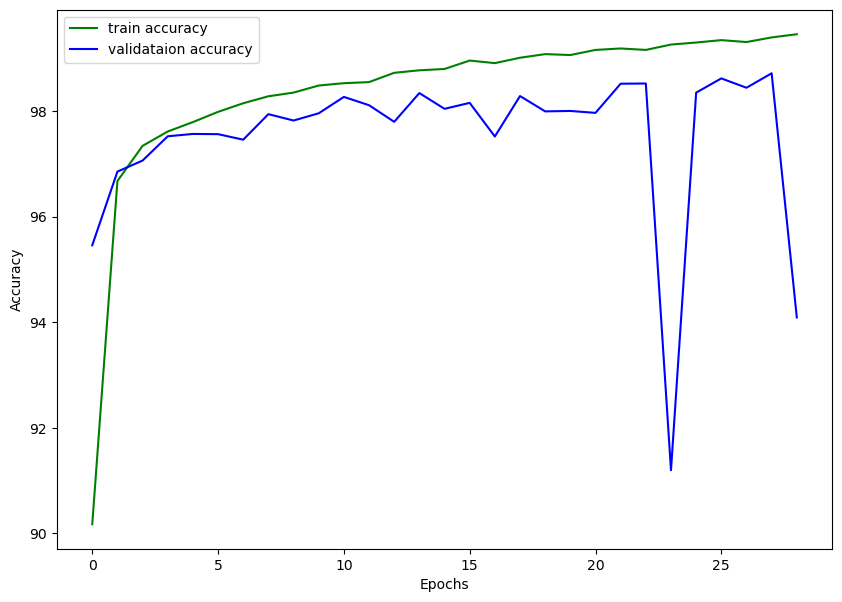

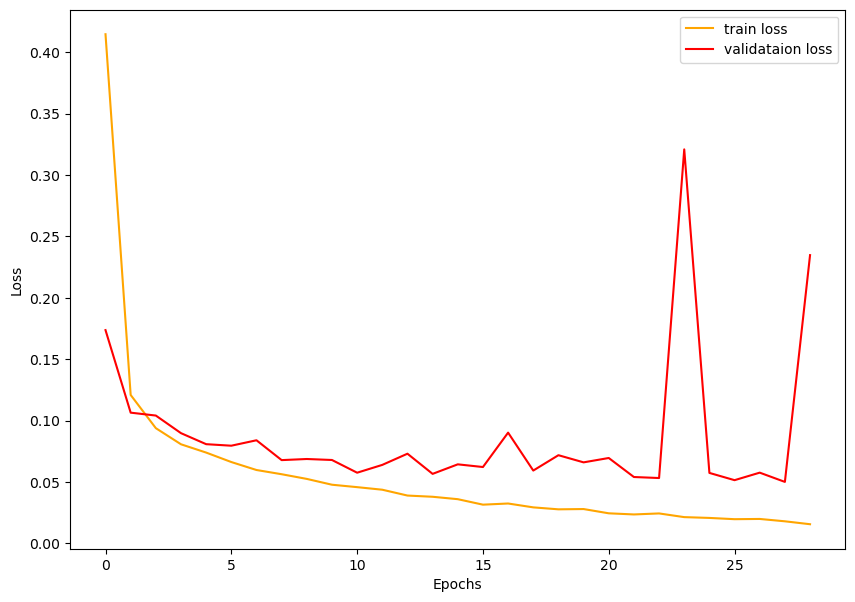

In [64]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

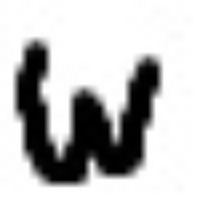

tensor([[ -56.1365,  -99.8780, -105.7220,  -73.9420,  -55.3876,  -76.3921,
          -92.1508,  -62.6763,  -90.4563,   -6.1677,  -82.0766, -112.3764,
          -93.3955,  -88.5477,  -67.9810,  -50.5936, -107.7143,  -77.6968,
         -103.0136,  -93.7993, -123.0570,  -51.8153,  -28.7454,  -92.0164,
         -127.7654,  -34.5270,  -75.3168,  174.3529,  -44.5782,  -48.8792,
          -29.0183,  -24.0338,  -75.4276, -105.2358,  -68.6608,  -28.6298,
          -55.4157,  -95.6297,  -42.4754,  -83.6843]], device='cuda:0',
       grad_fn=<MulBackward0>) omega


In [73]:
import cv2
from PIL import Image, ImageOps

model.eval()

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
print(pred*10, map_pred(pred.argmax().item()))

In [68]:
import cv2
from PIL import Image, ImageOps

m = mnt56.MathNet56()
m.load_state_dict(torch.load('models/mathnet'+str(IMAGE_SIZE)+'/mathnet.ml'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m = m.to(device)
m.eval()

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = m(x_image) 
print(pred*10, map_pred(pred.argmax().item()))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026F92753880>
Traceback (most recent call last):
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\site-packages\torch\utils\data\dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\Programs\Anaconda3\envs\MyPyTorch\Lib\multiprocessing\popen_spawn_win32.py", line 110, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


RuntimeError: Error(s) in loading state_dict for MathNet56:
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked". 
	size mismatch for block1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 1, 3, 3]).